<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 3 Assignment 1*

# Recurrent Neural Networks and Long Short Term Memory (LSTM)

![Monkey at a typewriter](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Chimpanzee_seated_at_typewriter.jpg/603px-Chimpanzee_seated_at_typewriter.jpg)

It is said that [infinite monkeys typing for an infinite amount of time](https://en.wikipedia.org/wiki/Infinite_monkey_theorem) will eventually type, among other things, the complete works of Wiliam Shakespeare. Let's see if we can get there a bit faster, with the power of Recurrent Neural Networks and LSTM.

This text file contains the complete works of Shakespeare: https://www.gutenberg.org/files/100/100-0.txt

Use it as training data for an RNN - you can keep it simple and train character level, and that is suggested as an initial approach.

Then, use that trained RNN to generate Shakespearean-ish text. Your goal - a function that can take, as an argument, the size of text (e.g. number of characters or lines) to generate, and returns generated text of that size.

Note - Shakespeare wrote an awful lot. It's OK, especially initially, to sample/use smaller data and parameters, so you can have a tighter feedback loop when you're trying to get things running. Then, once you've got a proof of concept - start pushing it more!

In [1]:
#Words, words, mere words, no matter from the heart.

### Ingest Data

In [40]:
# Generate Path to File
import os


filename = "shakespeare"

filepath = os.path.join(os.getcwd(), filename)

In [41]:
# Read all lines into dataframe for early processing
import pandas as pd


df = pd.read_table(
    filepath,
    header=None,
    skip_blank_lines=True,
    lineterminator=None,
    skiprows=136,
    error_bad_lines=False,
    verbose=False,
           )

df.head()

b'Skipping line 72156: expected 1 fields, saw 2\nSkipping line 107004: expected 1 fields, saw 2\n'


,0
0,1
1,"From fairest creatures we desire increase,"
2,"That thereby beauty’s rose might never die,"
3,"But as the riper should by time decease,"
4,His tender heir might bear his memory:


### Pre-Process Data

In [42]:
# Generate length of each line
def get_len(x):
    return len(x)

df.columns = ['text']

df['len'] = df.text.apply(get_len)

df.head()

,text,len
0,1,21
1,"From fairest creatures we desire increase,",42
2,"That thereby beauty’s rose might never die,",43
3,"But as the riper should by time decease,",40
4,His tender heir might bear his memory:,38


In [43]:
# Check distribution of len
import matplotlib.pyplot as plt
import seaborn as sns

sns.kdeplot(df.len), df.describe()

(<matplotlib.axes._subplots.AxesSubplot at 0x7f99381fffd0>,
                  len
 count  138502.000000
 mean       39.106627
 std        17.247505
 min         2.000000
 25%        29.000000
 50%        42.000000
 75%        49.000000
 max       500.000000)

In [44]:
# Truncate data between quantiles
# Lower Bound: 0.375
# Upper bound: 0.99

display(df.quantile(0.375), df.quantile(0.99))
df_trunc = df[(df.len > 26) & (df.len < 69)]
df_trunc.head()

len    39.0
Name: 0.375, dtype: float64

len    71.0
Name: 0.99, dtype: float64

,text,len
1,"From fairest creatures we desire increase,",42
2,"That thereby beauty’s rose might never die,",43
3,"But as the riper should by time decease,",40
4,His tender heir might bear his memory:,38
5,"But thou contracted to thine own bright eyes,",45


(<matplotlib.axes._subplots.AxesSubplot at 0x7f9938087450>,
                  len
 count  101327.000000
 mean       45.799392
 std         9.224490
 min        27.000000
 25%        40.000000
 50%        45.000000
 75%        50.000000
 max        68.000000)

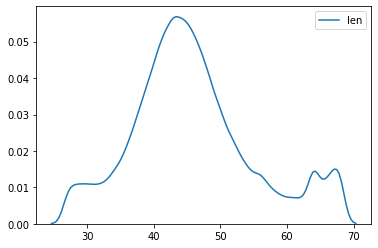

In [45]:
sns.kdeplot(df_trunc.len), df_trunc.describe()

In [46]:
# Drop end of document (endnotes)
df_trunc.tail(200)

,text,len
138127,Teaching decrepit age to tread the measures; ...,56
138128,"The staring ruffian shall it keep in quiet,",43
138129,"Pluck down the rich, enrich the poor with trea...",52
138130,"It shall be raging mad, and silly mild,",41
138131,"Make the young old, the old become a child. ...",56
...,...,...
138491,Gutenberg-tm eBooks with only a loose network ...,67
138492,Project Gutenberg-tm eBooks are often created ...,66
138494,the U.S. unless a copyright notice is included...,63
138499,how to make donations to the Project Gutenberg...,63


In [47]:
max(df_trunc.index)

138501

In [48]:
df_trunc = df_trunc[df_trunc.index < max(df_trunc.index)-200]

In [49]:
# Tokenize words and find length of tokenized vectors
from gensim.utils import simple_preprocess


def tokenize(x):
    return simple_preprocess(x, min_len=1)

df_trunc.text = df_trunc.text.apply(tokenize)
df_trunc.len = df_trunc.text.apply(get_len)

In [50]:
# Drop any lines with token length < 2
df_trunc = df_trunc[df_trunc.len > 2]
display(df_trunc.describe(), df_trunc.head())

,len
count,100742.000000
mean,8.461099
std,2.076196
min,3.000000
25%,7.000000
50%,8.000000
75%,10.000000
max,19.000000


,text,len
1,"[from, fairest, creatures, we, desire, increase]",6
2,"[that, thereby, beauty, s, rose, might, never,...",8
3,"[but, as, the, riper, should, by, time, decease]",8
4,"[his, tender, heir, might, bear, his, memory]",7
5,"[but, thou, contracted, to, thine, own, bright...",8


In [51]:
# Create Dictionary of Words
from gensim import corpora

dictionary = corpora.Dictionary(df_trunc.text)

# Save dictionary for future use
dictionary.save('shakespear_gensim_dictionary.dict')

In [13]:
# Create corpus (bag of words)
# Note the corpus is out of order, so it cannot be used to define sequences later on!
corpus = [dictionary.doc2bow(text) for text in df_trunc.text]

In [14]:
len(corpus)

100742

In [15]:
corpus[0]

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]

In [55]:
dictionary.token2id['heir'], dictionary[23]

(23, 'heir')

In [17]:
# Convert to data file
import numpy as np

data = []
for line in df_trunc.text:
    for word in line:
        data.append(dictionary.token2id[word])
        
data = np.array(data)

In [18]:
# Preview data
display(data[0:20], len(data))

array([ 3,  2,  0,  5,  1,  4, 12, 13,  6, 11, 10,  8,  9,  7, 15, 14, 20,
       18, 19, 16])

852388

In [19]:
# Check word indexing
sentence = ""
for word in data[0:10]:
    sentence += " "+dictionary[word]
    
sentence

' from fairest creatures we desire increase that thereby beauty s'

### Define RNN

In [136]:
# hyperparameters

txt_data_size = len(data)
num_chars = max(data)

iteration = 10
sequence_length = 10
batch_size = round((txt_data_size / sequence_length) + 0.5) # = math.ceil
hidden_size = 500  # size of hidden layer of neurons.  
learning_rate = 1e-1


# model parameters

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. 
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)


def forwardprop(inputs, targets, h_prev):
        
    # Since the RNN receives the sequence, the weights are not updated during one sequence.
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    hs[-1] = np.copy(h_prev) # Copy previous hidden state vector to -1 key value.
    loss = 0 # loss initialization
    
    for t in range(len(inputs)): # t is a "time step" and is used as a key(dic).  
        
        xs[t] = np.zeros((num_chars,1))
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) # hidden state.
        ys[t] = np.dot(W_hy, hs[t]) + b_y # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars.
        
        # Softmax. -> The sum of probabilities is 1 even without the exp() function, but all of the elements are positive through the exp() function.
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss). Efficient and simple code

#         y_class = np.zeros((num_chars, 1)) 
#         y_class[targets[t]] =1
#         loss += np.sum(y_class*(-np.log(ps[t]))) # softmax (cross-entropy loss)

    return loss, ps, hs, xs


def backprop(ps, inputs, hs, xs, targets):

    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy) # make all zero matrices.
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 

    # reversed
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t]) # shape (num_chars,1).  "dy" means "dloss/dy"
        dy[targets[t]] -= 1 # backprop into y. After taking the soft max in the input vector, subtract 1 from the value of the element corresponding to the correct label.
        dWhy += np.dot(dy, hs[t].T)
        dby += dy 
        dh = np.dot(W_hy.T, dy) + dhnext # backprop into h. 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients.  
    
    return dWxh, dWhh, dWhy, dbh, dby





In [146]:
inputs = data[data_pointer:data_pointer+sequence_length]
inputs

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Train RNN

In [147]:
%%time

data_pointer = 0
num_docs = len(corpus)

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 

for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size):
        
        inputs = data[data_pointer:data_pointer+sequence_length]
        targets = data[data_pointer+1:data_pointer+sequence_length+1]    # t + 1
            
        if (data_pointer+sequence_length+1 >= num_docs and b == batch_size-1): # processing of the last part of the input data. 
#             targets.append(char_to_int[txt_data[0]])   # When the data doesn't fit, add the first char to the back.
            targets.append(num_chars+1)   # When the data doesn't fit, add space(" ") to the back.


        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
#         print(loss)
    
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs, targets) 
        
        
    # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer
        
    if i % 100 == 0:
        print ('iter %d, loss: %f' % (i, loss)) # print progress

KeyboardInterrupt: 

### Define network in Keras

In [149]:
# Generate x_train, y_train, x_test, y_test
data[0:5]

array([0, 1, 2, 3, 4])

In [43]:
# Create X and y: random lengths from data(X) plus next word in sequence(y)
from multiprocessing import Pool

sequence_length = 10  # maximum sequence length
max_index = len(data)  # maximum index in data (prevent out_of_bounds indexing.  may still happen)
num_data_points = 80000  # Total number of data points to create
num_threads = 8  # Number of processes to spawn


def sample_random_data(num_data_points):
    temp_data = []
    for i in range(num_data_points):
        start = np.random.choice(range(max_index))
        length = sequence_length
        try:
            # Attempt to lookup and append sequence
            temp_data.append(
                data[start:start+length+1]
            )
        except:
            # If fail, step back the sequence length
            temp_data.append(
                data[start-length:start+1]
            )
    
    return temp_data


def sample_sequence_data(run_params):
    start_position = run_params[0]
    num_data_points = run_params[1]
    sequence_length = run_params[2]
    
    temp_data = []
    
    for i in range(num_data_points):

        try:
            # Attempt to lookup and append sequence
            temp_data.append(
                data[start_position:start_position+sequence_length+1]
            )
            start_position += 1
        except:
            # If fail, step back the sequence length
            temp_data.append(
                data[start-length:start+1]
            )
    
    return temp_data
    

# Generate param_list for sample_sequence_data
observations_per_thread = round(num_data_points/num_threads)
start_positions = [thread_number*(sequence_length+observations_per_thread) for thread_number in range(num_threads)]
sequence_lengths = [sequence_length]*num_threads
num_data_points = [observations_per_thread]*num_threads

run_params = list(zip(start_positions, num_data_points, sequence_lengths))

p = Pool(num_threads)
worker_list = p.map(sample_sequence_data, run_params)


# # sample_random_data multiprocessing execution: Not exact number of datapoints returned
# p = Pool(num_threads)
# observations_per_thread = round(num_data_points/num_threads)
# worker_list = p.map(sample_random_data, [observations_per_thread]*num_threads)

# # sample_sequence_data multiprocessing execution: Not exact number of datapoints returned


# Flatten list of lists returned by mutliprocessing into big dataset
dataset = []
for work in worker_list:
    dataset += work
    

    

Process ForkPoolWorker-31:
Process ForkPoolWorker-25:
Process ForkPoolWorker-32:
Process ForkPoolWorker-30:
Process ForkPoolWorker-28:
Process ForkPoolWorker-27:
Process ForkPoolWorker-29:
Process ForkPoolWorker-26:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/vbrandon/anaconda3/envs/tensorflow/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/vbrandon/anaconda3/envs/tensorflow/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/vbrandon/anaconda3/envs/tensorflow/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/vbrandon/anaconda3/envs/tensorflow/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._

In [53]:
dataset[0]

array([ 3,  2,  0,  5,  1,  4, 12, 13,  6, 11, 10])

In [2]:
import numpy as np

def pop_end(dataset):
    X = []
    y = []
    for x in dataset:
        X.append(x[0:len(x)-1]) 
        y.append(x[len(x)-1])
    
    return np.array(X), np.array(y)


X, y = pop_end(dataset)

display(X[0:5], y[0:5], len(set(y)))

array([[ 3,  2,  0,  5,  1,  4, 12, 13,  6, 11],
       [ 2,  0,  5,  1,  4, 12, 13,  6, 11, 10],
       [ 0,  5,  1,  4, 12, 13,  6, 11, 10,  8],
       [ 5,  1,  4, 12, 13,  6, 11, 10,  8,  9],
       [ 1,  4, 12, 13,  6, 11, 10,  8,  9,  7]])

array([10,  8,  9,  7, 15])

7362

In [48]:
# Save dataset out for future use
import pickle

with open('shakespeare_seq.pkl', 'wb+') as file:
    pickle.dump(dataset, file)

In [1]:
# Load dataset
import pickle

dataset = pickle.load(open('shakespeare_seq.pkl', 'rb'))
len(dataset)

80000

In [3]:
# Try one-hot encoding y
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

y_onehot = encoder.fit_transform(y.reshape(-1,1)).todense()

/home/vbrandon/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [4]:
# display y_onehot's shape and respective categories (important for future lookup to reconstruct text)
display(y_onehot.shape, encoder.categories_)

(80000, 7362)

[array([0.000e+00, 1.000e+00, 2.000e+00, ..., 7.360e+03, 7.361e+03,
        7.362e+03])]

In [5]:
# Create train, test split
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)

maxlen = 10

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test = sequence.pad_sequences(X_test, maxlen=maxlen)


In [8]:
X_train[0].shape

(10,)

In [10]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM

# Some parameters to play around with
batch_size = 32
num_classes = y_onehot.shape[1]


print('Build model...')
model = Sequential()
model.add(Embedding(5000, 300))
model.add(LSTM(300, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(300, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])




Build model...


In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dense_2 (Dense)              (None, 7362)              2215962   
Total params: 5,937,162
Trainable params: 5,937,162
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Train model
print('Train model')
model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(X_test, y_test))

Train model
Train on 64000 samples, validate on 16000 samples
Epoch 1/15
64000/64000 [==============================] - 121s 2ms/sample - loss: 4.1255 - accuracy: 0.1997 - val_loss: 6.8157 - val_accuracy: 0.0828
Epoch 2/15
64000/64000 [==============================] - 121s 2ms/sample - loss: 3.6332 - accuracy: 0.2677 - val_loss: 7.0437 - val_accuracy: 0.0817
Epoch 3/15
64000/64000 [==============================] - 120s 2ms/sample - loss: 3.2080 - accuracy: 0.3330 - val_loss: 7.2576 - val_accuracy: 0.0769
Epoch 4/15
64000/64000 [==============================] - 121s 2ms/sample - loss: 2.8481 - accuracy: 0.3941 - val_loss: 7.4428 - val_accuracy: 0.0781
Epoch 5/15
64000/64000 [==============================] - 120s 2ms/sample - loss: 2.5353 - accuracy: 0.4510 - val_loss: 7.6556 - val_accuracy: 0.0730
Epoch 6/15
64000/64000 [==============================] - 121s 2ms/sample - loss: 2.2661 - accuracy: 0.5012 - val_loss: 7.8306 - val_accuracy: 0.0719
Epoch 7/15
64000/64000 [==============

In [17]:
# Save model for future reference

model.save('shakespeare_model_1.h5')

In [18]:
# Score Model
score, acc = model.evaluate(X_test, y_test,
                            batch_size=batch_size)

16000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

### Examine Outputs, Summary, Notes

In [19]:
model.predict(X_test[0])

array([[3.48578382e-04, 4.41478696e-05, 8.82289896e-06, ...,
        3.29049508e-05, 2.23310144e-05, 4.05935789e-05],
       [2.82312413e-08, 2.82961878e-07, 4.26097358e-06, ...,
        1.28094072e-07, 1.30974768e-05, 1.28519048e-07],
       [1.07306776e-04, 1.24993303e-05, 1.97606758e-04, ...,
        2.08347410e-05, 7.83884389e-05, 5.95946915e-07],
       ...,
       [6.30703241e-08, 1.88096241e-08, 1.13067726e-05, ...,
        3.83882472e-08, 1.94013319e-05, 1.27184492e-07],
       [2.56267322e-06, 1.04739641e-07, 1.43485240e-05, ...,
        2.74618401e-06, 2.05817341e-05, 3.45236958e-06],
       [1.82626864e-05, 7.50335224e-04, 5.35492472e-05, ...,
        2.92237814e-06, 2.67143764e-06, 2.97258021e-06]], dtype=float32)

In [29]:
# Input transformer

def sample(preds):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

sample(model.predict(X_test[10000]))

9

In [67]:
# What is the output?


pred = model.predict(X_train[0])

def get_word_from_array(input_array):
    prob_max = max(input_array)
    column_loc = np.where(input_array == prob_max)[0][0]
    return dictionary[column_loc]
    

def get_word(token_id):
    return dictionary[token_id]


# Get the words initially passed in
print(" ".join(list(map(get_word, X_train[0]))))

# Check max_prob words coming out of model
print(" ".join([get_word_from_array(x) for x in pred]))

# See what the output should be
print(get_word_from_array(y_train[0]))

    

even so my sun one early morn did shine with
paler much lord liver good they knows not the the
creatures


# Resources and Stretch Goals

## Stretch goals:
- Refine the training and generation of text to be able to ask for different genres/styles of Shakespearean text (e.g. plays versus sonnets)
- Train a classification model that takes text and returns which work of Shakespeare it is most likely to be from
- Make it more performant! Many possible routes here - lean on Keras, optimize the code, and/or use more resources (AWS, etc.)
- Revisit the news example from class, and improve it - use categories or tags to refine the model/generation, or train a news classifier
- Run on bigger, better data

## Resources:
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) - a seminal writeup demonstrating a simple but effective character-level NLP RNN
- [Simple NumPy implementation of RNN](https://github.com/JY-Yoon/RNN-Implementation-using-NumPy/blob/master/RNN%20Implementation%20using%20NumPy.ipynb) - Python 3 version of the code from "Unreasonable Effectiveness"
- [TensorFlow RNN Tutorial](https://github.com/tensorflow/models/tree/master/tutorials/rnn) - code for training a RNN on the Penn Tree Bank language dataset
- [4 part tutorial on RNN](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) - relates RNN to the vanishing gradient problem, and provides example implementation
- [RNN training tips and tricks](https://github.com/karpathy/char-rnn#tips-and-tricks) - some rules of thumb for parameterizing and training your RNN